In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

2023-11-29 15:34:59.649448: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 15:34:59.695167: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 15:34:59.695200: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 15:34:59.695228: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 15:34:59.703159: I tensorflow/core/platform/cpu_feature_g

## Data Loading

In [13]:
x_train=np.load('../BraiNeoCare/Datasets/balanced_x_train_common_1s.npy', mmap_mode='r')[0:40000,...]
x_test=np.load('../BraiNeoCare/Datasets/balanced_x_test_common_1s.npy', mmap_mode='r')
y_train=np.load('../BraiNeoCare/Datasets/balanced_y_train_common_1s.npy', mmap_mode='r')[0:40000,...]
y_test=np.load('../BraiNeoCare/Datasets/balanced_y_test_common_1s.npy', mmap_mode='r')


In [14]:
y_train.sum()

23287.0

In [15]:
#shuffle the data
np.random.seed(42)
train_indices = np.arange(x_train.shape[0])
np.random.shuffle(train_indices)
x_train = x_train[train_indices].reshape(x_train.shape[0],256,12)
y_train = y_train[train_indices]
test_indices = np.arange(x_test.shape[0])   
np.random.shuffle(test_indices)
x_test = x_test[test_indices].reshape(x_test.shape[0],256,12)
y_test = y_test[test_indices]

## Tiny model

In [ ]:
model1=keras.Sequential(name="Podi_model_eka")
model1.add(layers.Input(shape=(1024,12)))
model1.add(layers.Conv1D(64, 3, activation="swish", padding="same"))
model1.add(layers.MaxPooling1D(2))
model1.add(layers.Conv1D(128, 13, activation="swish", padding="same"))
model1.add(layers.MaxPooling1D(2))
model1.add(layers.GlobalAveragePooling1D())
model1.add(layers.Dense(64, activation="swish"))
model1.add(layers.Dense(1))

optimizer=keras.optimizers.Adam(learning_rate=0.001)
loss=keras.losses.BinaryCrossentropy(from_logits=True)
F1 = keras.metrics.FBetaScore()
AUROC = tf.keras.metrics.AUC(curve='ROC', name = 'AUROC')
AUPRC = tf.keras.metrics.AUC(curve='PR', name = 'AUPRC')
model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', F1, AUROC, AUPRC])

In [ ]:
import os
check_point_path='model1_checkpoints/ckpt_{epoch:04d}'
# check_point_path=tf.train.latest_checkpoint(check_point_dir)
check_point_dir = os.path.dirname(check_point_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=check_point_path,save_weights_only=True,verbose=1)
model1.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test),callbacks=[cp_callback])


In [ ]:
model1.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

## Large model Simillar to Resnet50

In [ ]:
def block_type1(n_filters1,n_filters2, kernel, pad, x):
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(x)
    block1=layers.BatchNormalization()(block1)
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block1)
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block1)
    block1=layers.BatchNormalization()(block1)
    block1=layers.SpatialDropout1D(0.2)(block1)
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block1)
    block1=layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(block1)
    block1=layers.BatchNormalization()(block1)
    block1=layers.SpatialDropout1D(0.2)(block1)

    block1_o=layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(x)
    block1_o=layers.BatchNormalization()(block1_o)
    block1_o=layers.SpatialDropout1D(0.2)(block1_o)
    added1=layers.add([block1,block1_o])
    return layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(added1)

def block_type2(n_filters1,n_filters2, kernel, pad, x):
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(x)
    block=layers.BatchNormalization()(block)
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block)
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block)
    block=layers.BatchNormalization()(block)
    block=layers.SpatialDropout1D(0.2)(block)
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block)
    block=layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(block)
    block=layers.BatchNormalization()(block)
    block=layers.SpatialDropout1D(0.2)(block)

    added=layers.add([x,block])
    return layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(added)

In [ ]:
def create_model():
  Input=keras.Input(shape=(1024,12),name="Input_signal")
  x=layers.Conv1D(32,3,padding="same",activation='swish')(Input)
  x=layers.BatchNormalization()(x)
  x=layers.Conv1D(32,3,padding="same",activation='swish')(x)
  x=layers.MaxPool1D(2)(x)

  x1=block_type1(32,128,3,"same",x)
  x2=block_type2(32,128,3,"same",x1)
  x3=block_type2(32,128,3,"same",x2)
  x3=layers.AveragePooling1D(4)(x3)
  x4=block_type1(64,256,7,"same",x3)
  x5=block_type2(64,256,7,"same",x4)
  x6=block_type2(64,256,7,"same",x5)
  x7=block_type2(64,256,7,"same",x6)
  x7=layers.AveragePooling1D(4)(x7)
  x8=block_type1(128,512,9,"same",x7)
  x9=block_type2(128,512,9,"same",x8)
  x10=block_type2(128,512,9,"same",x9)
  x11=block_type2(128,512,9,"same",x10)
  x12=block_type2(128,512,9,"same",x11)
  x13=block_type2(128,512,9,"same",x12)
  x13=layers.AveragePooling1D(4)(x13)
  x14=block_type1(256,1024,11,"same",x13)
  x15=block_type2(256,1024,11,"same",x14)
  x16=block_type2(256,1024,11,"same",x15)
  x16=layers.GlobalAveragePooling1D()(x16)
  x16=layers.Dense(16,activation='swish')(x16)
  x16=layers.Dense(1)(x16)

  model=keras.Model(Input,x16)
  F1 = tfa.metrics.FBetaScore(num_classes=1)
  AUROC = tf.keras.metrics.AUC(curve='ROC', name = 'AUROC')
  AUPRC = tf.keras.metrics.AUC(curve='PR', name = 'AUPRC')
  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', F1, AUROC, AUPRC])
  keras.utils.plot_model(model,'model.png',show_layer_activations=True,show_shapes=True)
  model.summary()
  return model

model = create_model()


In [ ]:
keras.utils.plot_model(model,'/content/drive/MyDrive/FYP_ML/model1.png',show_shapes=True)

In [ ]:
model.fit(train_dataset, validation_data = test_dataset, epochs=100)

## Working large model

In [16]:
def block_type1(n_filters1,n_filters2, kernel, pad, x):
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(x)
    block1=layers.BatchNormalization()(block1)
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block1)
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block1)
    block1=layers.BatchNormalization()(block1)
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block1)
    block1=layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(block1)
    block1=layers.BatchNormalization()(block1)

    block1_o=layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(x)
    block1_o=layers.BatchNormalization()(block1_o)
    added1=layers.add([block1,block1_o])
    return layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(added1)

def block_type2(n_filters1,n_filters2, kernel, pad, x):
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(x)
    block=layers.BatchNormalization()(block)
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block)
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block)
    block=layers.BatchNormalization()(block)
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block)
    block=layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(block)
    block=layers.BatchNormalization()(block)

    added=layers.add([x,block])
    return layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(added)

In [23]:
def create_model():
  Input=keras.Input(shape=(256,12),name="Input_signal")
  x=layers.Conv1D(32,3,padding="same",activation='swish')(Input)
  y=layers.Conv1D(32,5,padding='same',activation='swish')(Input)
  a=layers.add([x,y])
  # x=layers.AveragePooling1D(2)(a)
  x=layers.MaxPooling1D(4)(a)

  x1=block_type1(32,128,3,"same",x)
  x2=block_type2(32,128,13,"same",x1)
  x3=block_type2(32,128,23,"same",x2)
  x3=layers.AveragePooling1D(4)(x3)
  x4=block_type1(64,256,7,"same",x3)
  x5=block_type2(64,256,17,"same",x4)
  x6=block_type2(64,256,27,"same",x5)
  x7=block_type2(64,256,7,"same",x6)
  x16=layers.GlobalAveragePooling1D()(x7)
  x16=layers.Dense(256)(x16)
  x16=layers.Dropout(0.5)(x16)
  x16=layers.Dense(16,activation='swish')(x16)
  x16=layers.Dense(1)(x16)

  model=keras.Model(Input,x16)
  F1 = tfa.metrics.FBetaScore(num_classes=1)
  AUROC = tf.keras.metrics.AUC(curve='ROC', name = 'AUROC')
  AUPRC = tf.keras.metrics.AUC(curve='PR', name = 'AUPRC')
  # used the followiing one to get 0.99 accuracy for 4s data
  # model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', F1, AUROC, AUPRC])

  optimizer=keras.optimizers.Adam(learning_rate=0.0005,)
  loss=keras.losses.BinaryCrossentropy(from_logits=True)
  model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy', F1, AUROC, AUPRC])
  # keras.utils.plot_model(model,'model.png',show_layer_activations=True,show_shapes=True)
  # model.summary()
  return model

model = create_model()


In [21]:
x_train=x_train*(10**5)
x_test=x_test*(10**5)

In [24]:
# used 128 as the batch size for 4s data
history=model.fit(x_train,y_train, validation_data = (x_test,y_test), epochs=100,batch_size=64)

Epoch 1/100
625/625 [==============================] - 115s 147ms/step - loss: 0.6537 - accuracy: 0.5373 - fbeta_score: 0.7359 - AUROC: 0.6223 - AUPRC: 0.7006 - val_loss: 0.6725 - val_accuracy: 0.6233 - val_fbeta_score: 0.6667 - val_AUROC: 0.6752 - val_AUPRC: 0.6558
Epoch 2/100
625/625 [==============================] - 38s 61ms/step - loss: 0.5610 - accuracy: 0.6758 - fbeta_score: 0.7359 - AUROC: 0.7490 - AUPRC: 0.8011 - val_loss: 0.6861 - val_accuracy: 0.6272 - val_fbeta_score: 0.6667 - val_AUROC: 0.6768 - val_AUPRC: 0.7342
Epoch 3/100
625/625 [==============================] - 37s 60ms/step - loss: 0.5010 - accuracy: 0.7236 - fbeta_score: 0.7359 - AUROC: 0.7895 - AUPRC: 0.8379 - val_loss: 0.5373 - val_accuracy: 0.6972 - val_fbeta_score: 0.6667 - val_AUROC: 0.7452 - val_AUPRC: 0.7863
Epoch 4/100
625/625 [==============================] - 38s 60ms/step - loss: 0.4653 - accuracy: 0.7541 - fbeta_score: 0.7359 - AUROC: 0.8150 - AUPRC: 0.8550 - val_loss: 0.5322 - val_accuracy: 0.7080 - va

KeyboardInterrupt: 

In [21]:
model.save('../BraiNeoCare/models/model1.h5')   

/home/nima/miniconda3/envs/BrainNeoCare/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model=keras.models.load_model('../BraiNeoCare/models/model1.h5')
model.summary()

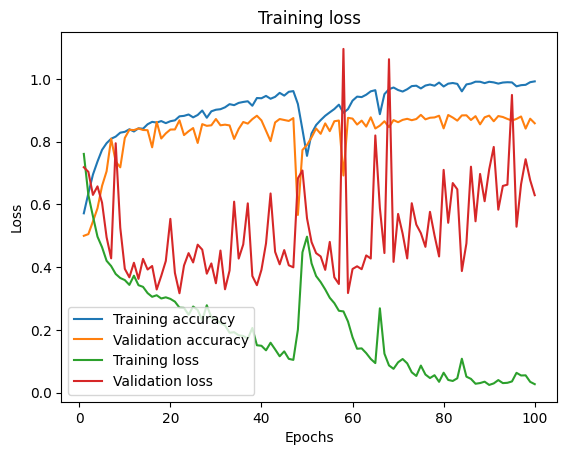

In [19]:
training_accuracy = history.history['accuracy']
val_accuracy=history.history['val_accuracy']
training_loss = history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Nima's model

In [ ]:
def create_model():
    i = keras.Input((1024,12), name='signal')
    x = layers.Conv1D(filters=72, kernel_size=15, activation='swish', padding='same')(i)
    a = layers.Conv1D(filters=72, kernel_size=1, padding='same')(i)
    a = layers.Add()([a,x])
    a = layers.Activation('swish')(a)
    x = layers.SpatialDropout1D(0.2)(a)
    b = layers.AveragePooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=144, kernel_size=3, activation='swish', padding='same')(b)
    a = layers.Conv1D(filters=144, kernel_size=1, padding='same')(b)
    a = layers.Add()([a,x])
    a = layers.Activation('swish')(a)
    x = layers.SpatialDropout1D(0.2)(a)
    b = layers.AveragePooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=288, kernel_size=5, activation='swish', padding='same')(b)
    a = layers.Conv1D(filters=288, kernel_size=1, padding='same')(b)
    a = layers.Add()([a,x])
    a = layers.Activation('swish')(a)
    x = layers.SpatialDropout1D(0.2)(a)
    b = layers.AveragePooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=576, kernel_size=7, activation='swish', padding='same')(b)
    a = layers.Conv1D(filters=576, kernel_size=1, padding='same')(b)
    a = layers.Add()([a,x])
    a = layers.Activation('swish')(a)
    b = layers.SpatialDropout1D(0.2)(a)
    x = layers.GlobalAveragePooling1D()(b)

    # j = keras.Input((2000,2*2), name='fft')
    # y = layers.Conv1D(filters=72, kernel_size=3, activation='swish', padding='same')(j)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.AveragePooling1D(pool_size=2)(y)
    # y = layers.Conv1D(filters=144, kernel_size=5, activation='swish', padding='same')(y)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.AveragePooling1D(pool_size=2)(y)
    # y = layers.Conv1D(filters=288, kernel_size=7, activation='swish', padding='same')(y)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.AveragePooling1D(pool_size=2)(y)
    # y = layers.Conv1D(filters=576, kernel_size=9, activation='swish', padding='same')(y)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.AveragePooling1D(pool_size=2)(y)
    # y = layers.Conv1D(filters=1152, kernel_size=11, activation='swish', padding='same')(y)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.GlobalAveragePooling1D()(y)

    # f = layers.Concatenate()([x,y])
    # f = layers.Activation('swish')(f)

    f = layers.Dense(576, activation='swish')(x)
    f = layers.Dropout(0.5)(f)
    f = layers.Dense(1,activation = 'sigmoid')(f)

    F1 = tfa.metrics.FBetaScore(num_classes=1)
    AUROC = tf.keras.metrics.AUC(curve='ROC', name = 'AUROC')
    AUPRC = tf.keras.metrics.AUC(curve='PR', name = 'AUPRC')
    model = keras.Model(i,f)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', AUROC, AUPRC])
    tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,layer_range=None, show_layer_activations=False)
    return model

with tpu_strategy.scope():
  model = create_model()


In [ ]:
tf.keras.utils.plot_model(model,'/content/drive/MyDrive/FYP_ML/model_nima.png')

In [ ]:
weight_for_0 = (1 / (tot-pos)) * (tot / 2.0)
weight_for_1 = (1 / pos) * (tot / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(train_dataset, validation_data = test_dataset, epochs=100)

## Small model

In [ ]:

# import tensorflow_addons as tfa
# from sklearn.model_selection import train_test_split

model=keras.Sequential(name="BrainNeoCare_CNN")
model.add(keras.layers.Conv2D(filters=32, kernel_size=(1,3), activation='relu', input_shape=(12,1024),name="Input_conv2D"))
model.add(keras.layers.MaxPooling2D((1,2),name="Maxpooling2D_1"))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(1,3), activation='relu',name="Conv2D_2"))
model.add(keras.layers.MaxPooling2D((1,2),name="Maxpooling2D_2"))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(1,3), activation='relu',name="Conv2D_3"))
model.add(keras.layers.MaxPooling2D((1,2),name="Maxpooling2D_3"))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(1,3), activation='relu',name="Conv2D_4"))
model.add(keras.layers.AveragePooling2D((1,2),name="AveragePooling2D_1"))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu',name="2D_F_Con"))
model.add(keras.layers.AveragePooling2D((1,2),name="AveragePooling2D_2"))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu',name="2D_F_Con_2"))
model.add(keras.layers.MaxPooling2D((1,2),name="AveragePooling2D_3"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu') )
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.BinaryCrossentropy(from_logits=False, name="binary_crossentropy",)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(train_dataset,epochs=10,verbose=1)

## Data manipulation and loading

In [ ]:
x=np.load('/content/drive/MyDrive/FYP_ML/zenodo_data.npy', mmap_mode='r')
y=np.load('/content/drive/MyDrive/FYP_ML/zenodo_labels.npy', mmap_mode='r')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)